In [1]:
from os.path import join, dirname, abspath
import mol_example
from chirho_diffeqpy.load_julia_env import LOADED_PACKAGES as LOADED_JULIA_PACKAGES, load_julia_env
from chirho_diffeqpy import DiffEqPy, ODEProblemWrapper, LogAtExtraDomains
from diffeqpy import de
import numpy as np
import torch
import matplotlib.pyplot as plt
from mol_example.run_and_render_jl_file import run_and_render_jl_file
from chirho.dynamical.handlers import LogTrajectory, StaticIntervention, StaticBatchObservation, DynamicIntervention
from chirho.dynamical.ops import simulate
import chirho_diffeqpy.lang_interop.julianumpy

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


In [2]:
# Load julia environment and prep access to julia files.
jl = load_julia_env()
julia_code_dir = dirname(abspath(mol_example.__file__))
# LOADED_JULIA_PACKAGES

# Define PDE and Discretize to ODE in Julia

In [3]:
run_and_render_jl_file(
    jl=jl,
    file_path=join(julia_code_dir, 'dirichlet_heat.jl')
)

┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation

┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154


In [4]:
ode_prob = jl.ode_prob

In [5]:
xx = torch.linspace(0.0, 1.0, 99)  # TODO HACK this just "happens" to be the same as the julia-side discretization. See below.

# TODO WIP one gotcha is that xx here HAS to align with the initial state xx. Because it will be used implicitly as the initial state
#  of any subsequent chunks of the simulation.
# I.e. LogAtExtraDomains is meh. we'd really like to recover exactly what the discretization is that the initial state needs to be defined on.
# Then we can 
#  1) require that the user provide an appropriate initial state
#  2) flatten/unflatten as desired and make sure that it lines up with the discretization.
#  3) already know what additional discretized domains we need to interpolate into.

In [6]:
# TODO btw somewhere we need to make clear that time must always be the first dimension of any solution. I.e. the julia definitions
#  need to follow this convention.

In [7]:
tspan = torch.linspace(0.0, 1.0, 101)

# Solve with Chirho API

In [8]:
solver = DiffEqPy(alg=de.Tsit5())

In [9]:
# Wrap the problem so that we can slot it in as the dynamics in the chirho api.
heat_dynamics = ODEProblemWrapper(ode_prob)
# These will be unpacked to the parameter vector in order.
atemp_params = dict(
    diffusion=torch.tensor(0.01),
    initial_condition_magnitude=torch.tensor(2.0),
    # This dynamic trigger will come into play later.
    dynamic_trigger=torch.tensor(-1.3)
)
initial_state = dict(
    u=atemp_params['initial_condition_magnitude'] * torch.cos(10. * xx)
)

In [10]:
# Parameters should line up.
from chirho_diffeqpy.internals import _flatten_mapping
assert _flatten_mapping(atemp_params).shape == torch.tensor(ode_prob.p).shape

In [11]:
with solver, LogTrajectory(times=tspan) as lt, LogAtExtraDomains(xx):
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    102-element Vector{Float64}:
│     0.0
│     0.01
│     0.02
│     0.03
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


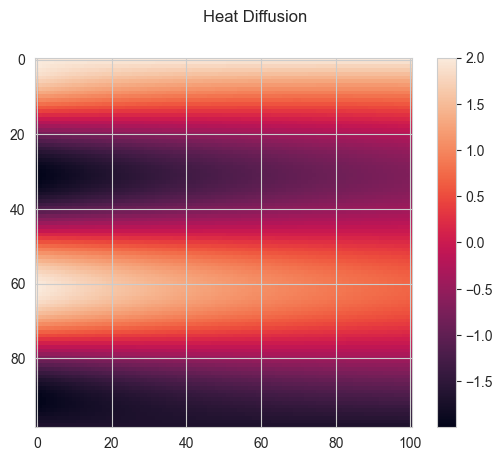

In [12]:
plt.imshow(lt.trajectory['u'].detach())
plt.suptitle('Heat Diffusion')
plt.colorbar()

# Simulate with Temporal Intervention

In [13]:
def heat_sink_intervention_fn(u):
    u = u.clone()
    u[59:65] = -2.0
    return u

heat_sink = StaticIntervention(
    time=tspan[67]-1e-10,
    intervention=dict(
        u=heat_sink_intervention_fn
    )
)

In [14]:
with solver, LogTrajectory(times=tspan) as lt_static, LogAtExtraDomains(xx), heat_sink:
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    36-element Vector{Float64}:
│     0.6699999999
│     0.67
│     0.6799999999999999
│     0.69
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


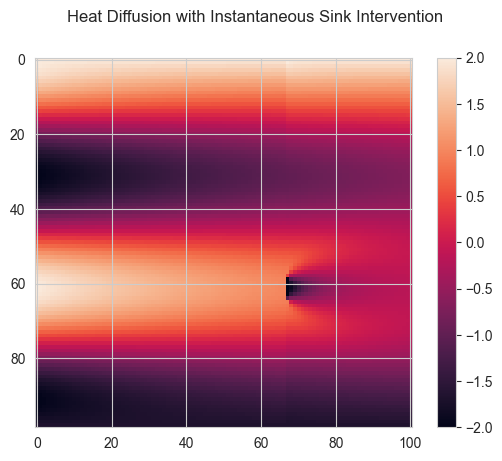

In [15]:
plt.imshow(lt_static.trajectory['u'].detach())
plt.suptitle('Heat Diffusion with Instantaneous Sink Intervention')
plt.colorbar()

# Simulate with State-Dependent Intervention

In [16]:
def temperature_event_fn(t, state, atemp_params):
    # Trigger an event when the temperature at discrete element 25 crosses -0.5
    return state['u'][25] - atemp_params['dynamic_trigger']

In [17]:
def heat_spike_intervention_fn(u):
    u = u.clone()
    u[20:25] = 2.0
    return u

heat_spike = DynamicIntervention(
    event_fn=temperature_event_fn,
    intervention=dict(
        u=heat_spike_intervention_fn
    )
)

In [18]:
with solver, LogTrajectory(times=tspan) as lt_dynamic, LogAtExtraDomains(xx), heat_spike:
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.23568846557940445
│     0.23568846557940445
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    79-element Vector{Float64}:
│     0.23568846557940445
│     0.24
│     0.25
│     0.26
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


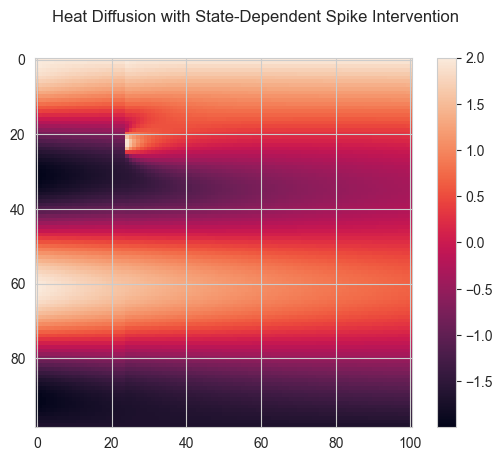

In [19]:
plt.imshow(lt_dynamic.trajectory['u'].detach())
plt.suptitle('Heat Diffusion with State-Dependent Spike Intervention')
plt.colorbar()

# Simulate with Both

In [20]:
with solver, LogTrajectory(times=tspan) as lt_both, LogAtExtraDomains(xx), heat_sink, heat_spike:
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.23568846557940445
│     0.23568846557940445
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    36-element Vector{Float64}:
│     0.6699999999
│     0.67
│     0.6799999999999999
│     0.69
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


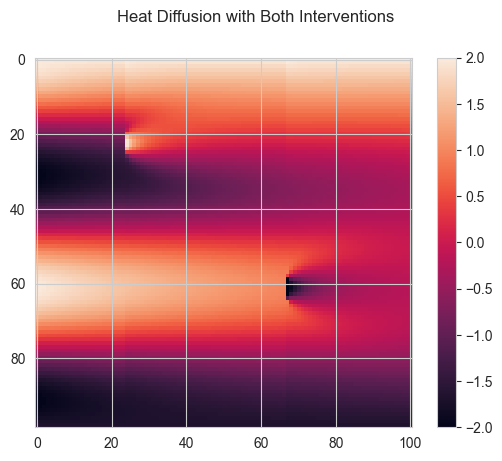

In [21]:
plt.imshow(lt_both.trajectory['u'].detach())
plt.suptitle('Heat Diffusion with Both Interventions')
plt.colorbar()

# Inference

Now, we'll perform joint inference over four parameters:
1. The diffusion coefficient
2. The initial condition magnitude
3. The static heat sink time
4. The dynamic heat spike trigger

We'll condition on a sparse, noisy observation of the temperature field in the middle and end of the simulation.

In [64]:
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal, AutoDelta
from pyro import sample
from chirho.observational.handlers import condition
from copy import copy
from chirho.observational.handlers.predictive import PredictiveModel

In [ ]:
pyro.settings.set(module_local_params=True)
pyro.set_rng_seed(9012)

##### Stochastic Model

In [102]:
def prior():
    return dict(
        diffusion=sample("diffusion", dist.LogNormal(-4.0, 1.2)),
        initial_condition_magnitude=sample("initial_condition_magnitude", dist.Uniform(0.5, 2.0)),
        # TODO HACK b/c discontinuous and maybe breaking grads.
        # dynamic_trigger=sample("dynamic_trigger", dist.Normal(-1.0, .5)),
        # static_trigger=sample("static_trigger", dist.Uniform(0.0, 1.0))
        dynamic_trigger=torch.tensor(-1.4),
        static_trigger=torch.tensor(0.8)
    )

In [103]:
OBS_IDX = torch.tensor([20, 40, 60, 80])
OBS_TIMES = torch.linspace(0.0, 1.0, 10)
def observation_fn(state):
    u_at_idx = state['u'][OBS_IDX]
    return sample("u_obs", dist.Normal(u_at_idx, 0.1).to_event(2))

# Must return None.
def observation_model(state):
    observation_fn(state)

In [104]:
def non_stochastic_model(atemp_params):
    atemp_params = copy(atemp_params)
    static_trigger = atemp_params.pop('static_trigger')
    
    heat_sink = StaticIntervention(
        time=static_trigger,
        intervention=dict(
            u=heat_sink_intervention_fn
        )
    )
    
    heat_spike = DynamicIntervention(
        event_fn=temperature_event_fn,
        intervention=dict(
            u=heat_spike_intervention_fn
        )
    )
    
    with LogAtExtraDomains(xx), heat_sink, heat_spike:
        end_state = simulate(
            heat_dynamics,
            initial_state,
            torch.tensor(0.0),
            torch.tensor(1.0),
            atemp_params=atemp_params,
        )
    return end_state

In [105]:
def model():
    temporal_obs = StaticBatchObservation(times=OBS_TIMES, observation=observation_model, is_traced=True)
    with solver, temporal_obs:
        return non_stochastic_model(prior())

##### Prior Predictive

In [106]:
# Prior predictive end state distributions.
prior_predictive_end_states_list = []
NSAMPLES = 500
for i in range(NSAMPLES):
    prior_predictive_end_states_list.append(
        model()
    )
    # print(f"Progress: {i+1}/{NSAMPLES}", end='\r')

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.05219084858309246
│     0.05219084858309246
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    4-element Vector{Float64}:
│     0.8
│     0.8888888888888888
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.016256006418106525
│     0.016256006418106525
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.

In [107]:
prior_predictive_end_states = torch.stack([end_state['u'] for end_state in prior_predictive_end_states_list])

Text(0.5, 1.0, 'Prior Predictive End States')

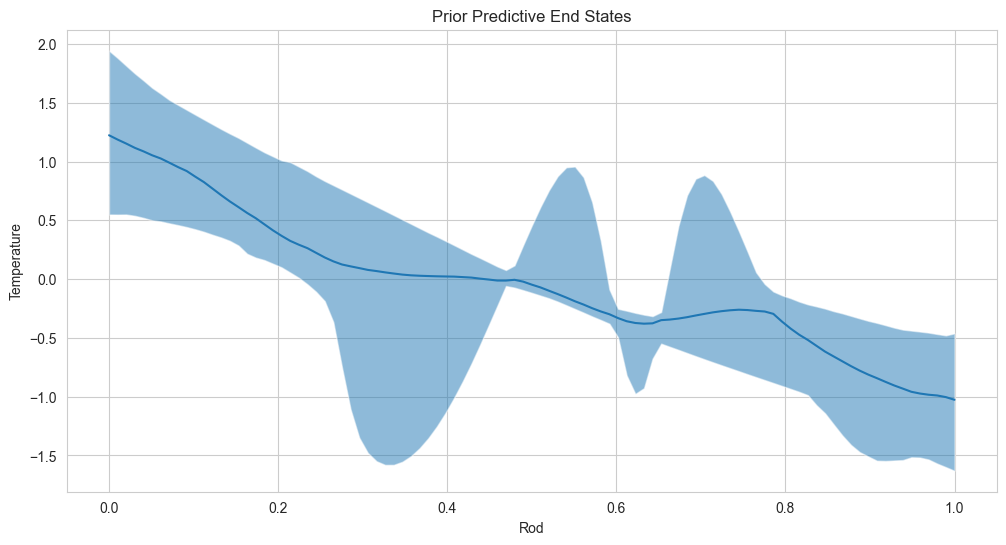

In [108]:
# Plot prior predictive end states with plt.fill_between the elementwise 95% CI.
def plot_end_states(end_state_samples):
    plt.figure(figsize=(12, 6))
    plt.fill_between(xx, *np.percentile(end_state_samples.detach().numpy(), [2.5, 97.5], axis=0), alpha=0.5)
    plt.plot(xx, np.median(end_state_samples.detach().numpy(), axis=0))
    plt.xlabel('Rod')
    plt.ylabel('Temperature')
    
plot_end_states(prior_predictive_end_states)
plt.title('Prior Predictive End States')

##### Synthetic Data

In [109]:
# Generate synthetic data.
true_params = dict(
    diffusion=torch.tensor(0.007),
    initial_condition_magnitude=torch.tensor(1.9),
    dynamic_trigger=torch.tensor(-1.4),
    static_trigger=torch.tensor(0.8)
)
with pyro.poutine.trace() as tr:
    with condition(data=true_params), LogTrajectory(times=tspan) as lt_true:
        true_end_u = model()['u']

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.23494623325599173
│     0.23494623325599173
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    59-element Vector{Float64}:
│     0.23494623325599173
│     0.24
│     0.25
│     0.26
│     ⋮
│     0.79
│     0.8
│     0.8
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    4-element Vector{Float64}:
│     0.8
│     0.8888888888888888
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots wer

In [110]:
observations = tr.trace.nodes['u_obs']['value']
observations.shape

torch.Size([4, 10])

In [111]:
true_u = lt_true.trajectory['u']

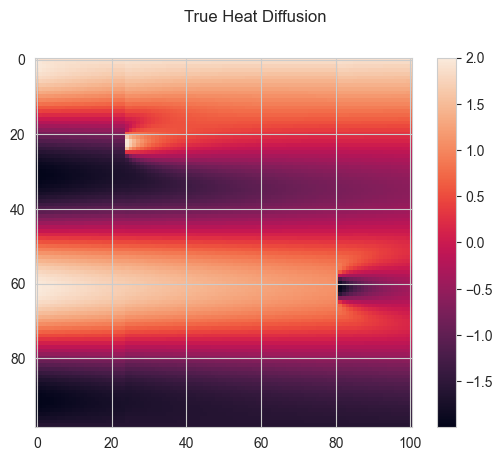

In [112]:
plt.imshow(true_u.detach())
plt.suptitle('True Heat Diffusion')
plt.colorbar()

Text(0.5, 1.0, 'True Heat Diffusion and Prior Predictive End States')

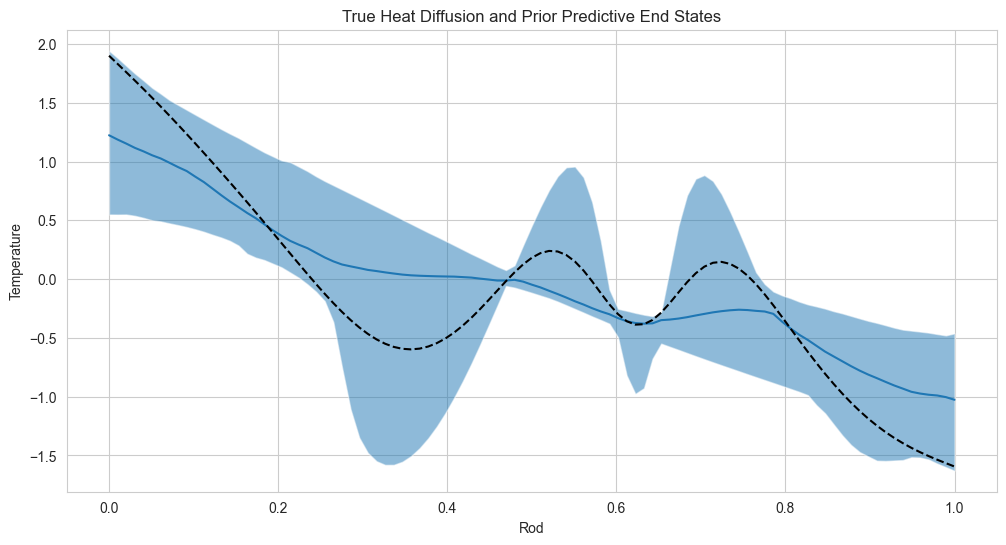

In [113]:
# Overlay the true end state on the prior predictive.
plot_end_states(prior_predictive_end_states)
plt.plot(xx, true_end_u.detach().numpy(), 'k--')
plt.title('True Heat Diffusion and Prior Predictive End States')

##### Variational Inference

In [114]:
# First, gradcheck wrt the parameters.
grad_atemp_params = {k: v.clone().detach().requires_grad_() for k, v in true_params.items()}

with solver, LogAtExtraDomains(xx):
    end_state = non_stochastic_model(grad_atemp_params)
    end_state['u'].sum().backward()

for k, v in grad_atemp_params.items():
    print(f"Gradient wrt {k}: {v.grad}")

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.23494623325599173
│     0.23494623325599173
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#7#8"{Py, PyArray{Float64, 1, true, true, Float64}}, Float64}, Float64, 12}}:
│     Dual{ForwardDiff.Tag{var"#7#8"{Py, PyArray{Float64, 1, true, true, Float64}}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
│     Dual{ForwardDiff.Tag{var"#7#8"{Py, PyArray{Float64, 1, true, true, Float64}}, Float64}}(0.23494623328173575,-5.197783842870123e-6,-1.2838317678679462e-5,-2.6222975640715275e-5,-5.054910503733554e-5,-9.430201491569488e-5,-0.00017116144521636177,-0.000302533073428

Gradient wrt diffusion: 999.6895484948415
Gradient wrt initial_condition_magnitude: 1.7167978114788673
Gradient wrt dynamic_trigger: -1.861366600305633
Gradient wrt static_trigger: 5.2897714321077025


In [115]:
def build_svi(model):
    guide = AutoDelta(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    elbo()  # initialize parameters.
    optim = torch.optim.Adam(elbo.parameters(), lr=1e-3)
    losses = []
    
    def svi_iter():
        optim.zero_grad()
        loss = elbo()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().item())
    
    return svi_iter, guide, losses

In [116]:
conditioned_model = condition(model, data=dict(u_obs=observations))

In [117]:
svi_iter, guide, losses = build_svi(conditioned_model)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.10749296210590421
│     0.10749296210590421
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    4-element Vector{Float64}:
│     0.8
│     0.8888888888888888
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.10749296210590421
│     0.10749296210590421
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.de

In [126]:
NITER = 300
with LogAtExtraDomains(xx):  # FIXME HACK b/c somehow the backward call doesn't have this?
    for i in range(NITER):
        svi_iter()
        # print(f"Progress: {i+1}/{NITER}, Loss: {losses[-1]}", end='\r')

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.1478346597458151
│     0.1478346597458151
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    4-element Vector{Float64}:
│     0.8
│     0.8888888888888888
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    4-element Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#7#8"{Py, PyArray{Float64, 1, true, true, Float64}}, Float64}, Float64, 12}}:
│     Dual{ForwardDiff.Tag{var"#7#8"{Py, PyArray{Float64, 1, true, true, Float64}}, Float64}}(0.8,0.0,0.0,0.0,0

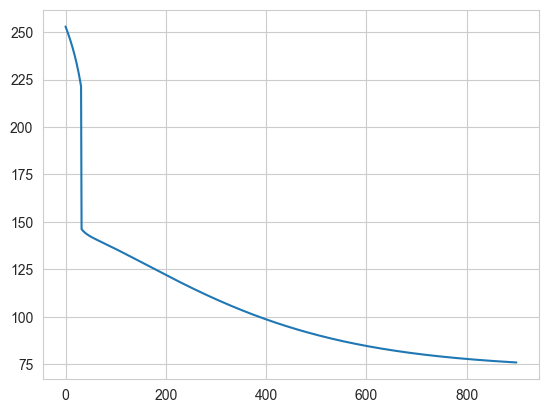

In [127]:
# Plot loss
plt.plot(losses)

In [128]:
map_model = PredictiveModel(model, guide)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.16277265028008112
│     0.16277265028008112
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    4-element Vector{Float64}:
│     0.8
│     0.8888888888888888
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


Text(0.5, 1.0, 'MAP Heat Diffusion and Prior Predictive End States')

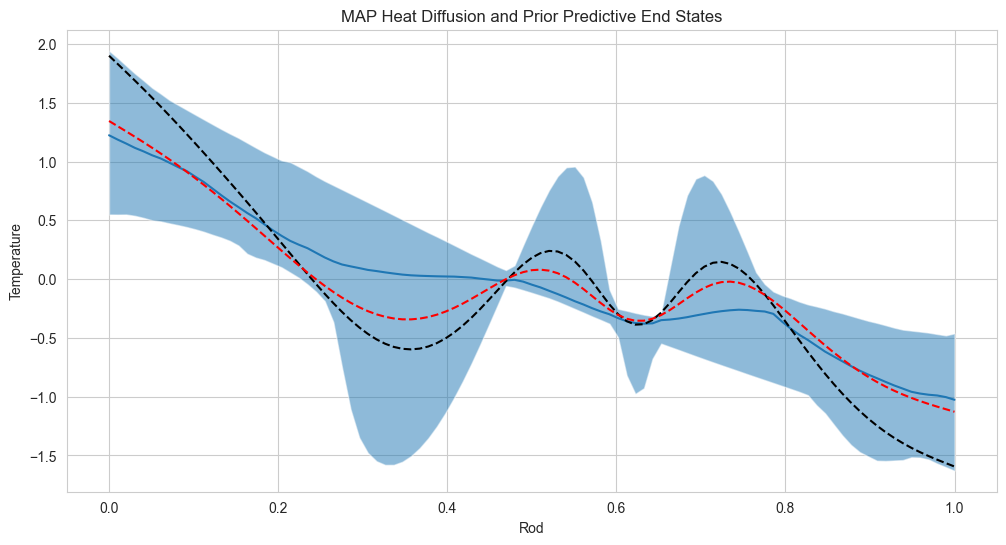

In [129]:
# Plot map end state alongside truth and prior predictive. 
map_end_u = map_model()['u']
plot_end_states(prior_predictive_end_states)
plt.plot(xx, true_end_u.detach().numpy(), 'k--')
plt.plot(xx, map_end_u.detach().numpy(), 'r--')
plt.title('MAP Heat Diffusion and Prior Predictive End States')